# An Introduction to Dynamic Mode Decomposition (DMD)

## Goal:

Approximate the leading eigencomposition of (high dimensional) linear operator $A \in \mathbb{C}^{n \times n}$ where $X'=AX$ to find spacial temporal coherant modes of the (possibly non-linear) system. 

In [23]:
from matplotlib import rcParams, rc, cm
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.animation as ani

import torch as pt
import numpy as np

pt.__version__

'1.7.1'

## Inputs to DMD

$n$ is the number of spatial points saved per shot and $m$ is the number of snapshots taken.

- Snapshot of fluid flow (long and skinny) $X = 
 \begin{bmatrix}
  \vert & \vert &     & \vert \\
  x_1   & x_2   & ... & x_{m-1} \\
  \vert & \vert &     & \vert
 \end{bmatrix} \in \mathbb{C}^{n \times (m-1)}$

- Snapshot of fluid flow evolved by one unit in time $X' = 
 \begin{bmatrix}
  \vert & \vert &     & \vert \\
  x_2   & x_3   & ... & x_{m} \\
  \vert & \vert &     & \vert
 \end{bmatrix} \in \mathbb{C}^{n \times (m-1)}$

 ### Inputs
 In this introduction, we will add together the following functions f1, f2, and f3 to create artificial test data:

In [3]:
def f1(Xm, Tm, z):
    return pt.multiply(20-0.2*pt.pow(Xm, 2), pt.exp(z*Tm)).T

def f2(Xm, Tm, z):
    return pt.multiply(Xm, pt.exp(z*Tm)).T

def f3(Xm, Tm, z):
    return pt.multiply(10*pt.tanh(Xm/2)/pt.cosh(Xm/2), pt.exp(z*Tm)).T

### Meshgrid
A small meshgrid is created for calculating points of the functions. 

*Note: The inputs of Pytorch.meshgrid(t,x) are flipped compared to numpy.meshgrid(x,t). See [documentation](https://pytorch.org/docs/master/generated/torch.meshgrid.html).*

In [4]:
def create_mesh(x_start, x_end, n_x, t_start, t_end, n_t):
    x = pt.linspace(x_start, x_end, n_x)
    t = pt.linspace(t_start, t_end, n_t)
    return pt.meshgrid(t, x)

# DMD at a Glance:

**1. Compute Singular Value Decomposition (SVD) of big data matrix $X$ to find the dominant coherent structures (Columns of $U$).**

The exact SVD is reduced when, for example, 99% of the system energy is captured by the first $r$ comumns of $U$. The * denotes the conjugate transpose.

$$ X = U\Sigma V^* $$

**2. Project $A$ on the dominant singular vectors $U^*$ and $U$ to get the reduced dynamic operator $\tilde{A}$**

$X$ is replaced in $X' = AX$ with matrices from the SVD, which results in $ X' = AU\Sigma V^* $. Instead of doing a (very demanding) pseudo-inverse to find $A$, we project $\tilde{A}$ onto our dominant singluar vectors $U^*$ and $U$. $\tilde{A}$, which is only of the magnitude of time (much smaller than $A$), is a linear best fit dynamical system, that tell you how your POD modes evolve over time.

$$U^*X'V\Sigma^{-1} = U^*AU = \tilde{A}$$

**3. Compute the eigenvalues $\Lambda$ and eigenvectors $W$ of $\tilde{A}$**

$\tilde{A}$ has the same non-zero *eigenvalues* as $A$.

$$\tilde{A}W = W\Lambda$$

**4. Compute the eigenvectors $\Phi$ of $A$**

The eigenvectors $\Phi$ are also called modes.

$$\Phi = X'V\Sigma^{-1}W$$

### Singular Value Decomposition (SVD)

A function is defined to compute the SVD, which will be used for the DMD later. pt.svd() returns the reduced SVD by default.

pt.svd returns $V$, not $V*$ (conj. transposed), which is useful, since we need $V$ for step 4. $\Sigma$ will always be a real-valued, which is important for this example.

We truncate at 3 modes (Why?)

Columns of U are our POD modes. For more on POD, check out the [notebook](POD_introduction.ipynb).

*Note: torch.svd() is depricated. In torch 1.8, [torch.linalg.svd](https://pytorch.org/docs/1.8.0/linalg.html#torch.linalg.svd) will function like numpy.linalg.svd(), but this is not available in Version 1.7.1*

In [34]:
def svd(matrix, rank=None):
    U, s, V = pt.svd(matrix, some=False)  #returns V, not V*
    if rank is None:
        rank = s.shape[0]
    return U[:, :rank], s[:rank], V[:, :rank]

### Dynamic Mode Decomposition (DMD)

After finding the SVD of our matrix, we can find $\tilde{A} = U^*X'V\Sigma^{-1}$.

$\Sigma$ is a diagonal matrix and can therefore be inversed using 1/diag_elements.

After finding $\tilde{A}$, the eigenvalues and eigenvectors can be computed using pt.eig(). Since Pytorch does not currently support complex tensor operations (see [forum](https://discuss.pytorch.org/t/how-to-use-complex-eigenvalues/71983)), we will use np.linalg.eig() for this example.

Finally, the eigenvectors of A $\Phi$ are computed and returned together with the eigenvalues (same for A and At). 

In [18]:
def dmd(matrix, rank=None):
    U, s, V = svd(matrix[:,:-1], rank)
    s_inv = pt.diag(1.0/s).type(pt.complex64) #type cast since Sigma is real (not necessary when using only real data)
    
    At = U.conj().T @ matrix[:, 1:] @ V @ s_inv #At = torch.mm(torch.mm(torch.mm(U.conj().T, matrix[:, 1:]), V), s_inv) not necessary because @ works too
    
    val, vec = np.linalg.eig(At)
    #val, vec = torch.eig(At, eigenvectors=True)
    
    phi = matrix[:, 1:] @ V @ s_inv @ vec
    return (val, phi)

### Creating Data and calling DMD function

The mesh is created, the functions are combined, and the DMD function is called. We pass rank=3, since we already know that the data should contain 3 modes.

*Note: PyTorch has no built in Pi-Function, so we "create" our own. See [forum post](https://discuss.pytorch.org/t/np-pi-equivalent-in-pytorch/67157).*

In [22]:
def main():    
    pt.pi = pt.acos(pt.zeros(1)).item()*2 # PyTorch has no built in Pi function

    Tm, Xm = create_mesh(-10, 10, 100, 0, 6*pt.pi, 80)
    X_1r = f1(Xm, Tm, -0.05+2.3j)
    X_2 = f2(Xm, Tm, 0.6j)
    X_3r = f3(Xm, Tm, 0.1+2.8j)
    data = X_1r + X_2 + X_3r
    
    rank=3
    dmd(data, rank=rank)

if __name__ == "__main__":
    main()

torch.complex64
torch.float32
torch.complex64


## Visualisations

To more clearly show stuff, here some pictures.

In [52]:
#code for pics

## Now what?


With our (spacial) modes $\Phi$ and (temporal) eigenvalues $\Lambda$, we can predict what the system will do in the future.

$$\hat{X}(k\Delta t) = \Phi\Lambda^kb_0$$

$\hat{X}$ is a future state prediction of $X$.

$\Lambda^k$ advances one time increment $\Delta t$ with each $k$.

$b_0$ is amplitude of modes. Condition for how much each mode is expressed in the data.

## Questions:

- use docstring with ''' notation, look at flowtorch/data/foamdataloader source code

- is rank of DMD always known? why do we truncate if we can do econ SVD? Can we find rank using dominant coherant structures of U? Is that what s.shape[0] does?

- In [28] bei notebook viewer total durcheinanader. 

- is the "now what" correct?

## References

1. Kutz, J. N., Brunton, S. L. 1., Brunton, B. W., & Proctor, J. L. (2016). *Dynamic Mode Decomposition.* Philadelphia, PA, USA: Society for Industrial and Applied Mathematics.
2. Taylor, R. (2016) Dynamic Mode Decomposition in Python. *Pyrunner.* Accessed: 25 January 2021. http://www.pyrunner.com/weblog/2016/07/25/dmd-python/
    

# Euler Data:

When only $Im$: $f_1(x) = (20-0.2x^2)e^{zt}, z=2.3j$

When $Re$ and $Im$: $f_1(x) = (20-0.2x^2)e^{zt}, z=-0.05 + 2.3j$

$f_1(x) = e^{-0.05t}(20-0.2x^2)e^{zt}, z=2.3j$

the amplitude of this is constantly decreasing.

# Test Cell:

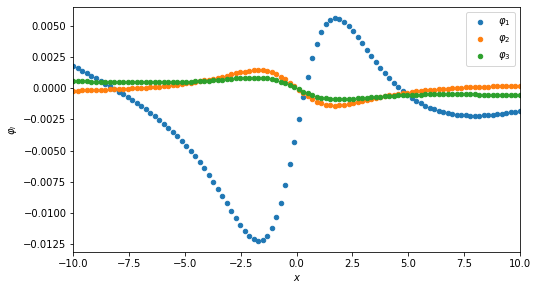

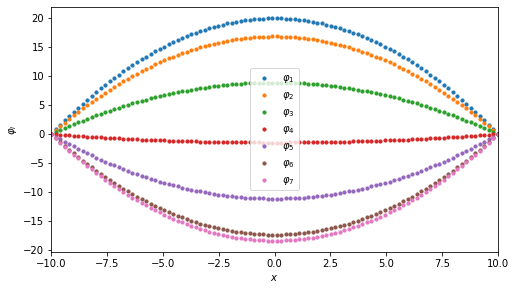

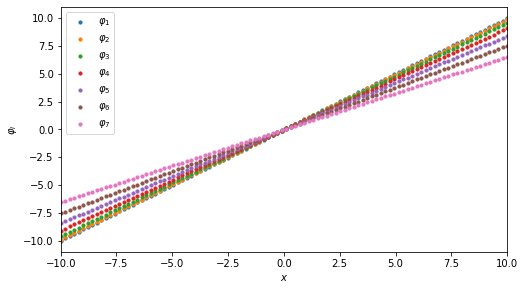

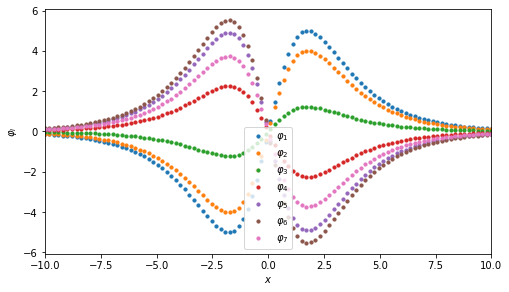

In [51]:
def plot_dmd_modes(x, modes, path):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    for i in range(modes.shape[1]):
        ax.scatter(x, pt.real(modes[:, i]), s=20, label=r"${:s}_{:d}$".format(r"{\varphi}", i+1))
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"${\varphi}_i$")
    ax.set_xlim(pt.min(x), pt.max(x))
    ax.legend()
    plt.savefig(path, bbox_inches="tight")
    
def plot_data(x, modes, path):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    for i in range(7):
        ax.scatter(x, pt.real(modes[:, i]), s=10, label=r"${:s}_{:d}$".format(r"{\varphi}", i+1))
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"${\varphi}_i$")
    ax.set_xlim(pt.min(x), pt.max(x))
    ax.legend()
    plt.savefig(path, bbox_inches="tight")
    
def animate_1D_sum(x, t, X, title, ylim, path):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    sc = []
    alpha = [0.1 for i in range(len(title))]
    alpha[0] = 1
    for i in range(len(title)):
        sc.append(ax.scatter([], [], s=10, label=title[i], alpha=alpha[i]))
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$Re(f(x))$")
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(*ylim)
    text = ax.set_title(r"$t={:2.2f}$".format(t[0]))
    ax.legend(loc="upper right")
    movie = ani.FuncAnimation(
        fig, update_1D_plot, frames=len(t), fargs=(x, t, X, sc, text))
    writer = ani.FFMpegWriter(bitrate=500)
    movie.save(path, writer=writer)    
    
def main():
    Tm, Xm = create_mesh(-10, 10, 100, 0, 6*pt.pi, 80)
    X_1r = f1(Xm, Tm, -0.05+2.3j)
    X_2 = f2(Xm, Tm, 0.6j)
    X_3r = f3(Xm, Tm, 0.1+2.8j)
    data = X_1r + X_2 + X_3r

    rank=3
    val, phi = dmd(data, rank=rank)
    
    plot_dmd_modes(Xm[0,:], phi, "dmd_modes.svg")
    
    plot_data(Xm[0,:], X_1r, "f1.svg")
    
    plot_data(Xm[0,:], X_2, "f1.svg")
    
    plot_data(Xm[0,:], X_3r, "f1.svg")
    
    

if __name__ == "__main__":
    main()

![SegmentLocal](f1_f2_f3.gif "segment")